# Reinforcement Learning Example

This lab is coming from [this post](https://towardsdatascience.com/deep-reinforcement-learning-build-a-deep-q-network-dqn-to-play-cartpole-with-tensorflow-2-and-gym-8e105744b998). You can find their code on their github but I copy past it here to explain it to you. 

In this example, we will train a DQN on a well known example : Cartpole. The objective is to prevent a pendulum from falling over. The pendulum is on a cart that moves along a track. Through moving the cart, you have to ensure that the pendulum doesn't fall and that the cart doesn't go too far from the origin.

NB : The env.render() that usually provides a visualisation in Gym doesn't work in a Google Colab but you can run the Python code locally.

In [0]:
import numpy as np
import tensorflow as tf
import gym
import os
import datetime
from gym import wrappers
import matplotlib.pyplot as plt

The model is just a Feed Forward Neural Network. We are stacking dense layers. The task of this network is to decide what should be the next action based on the observation (state vector). So, as an input, you can find the *num_states* and *num_actions* units for the output layer.

Instead of stacking layers as we've seen in the sequential model, we define the layers in the *init* and define their relationships in the *call* method.

In [0]:
class MyModel(tf.keras.Model):
    def __init__(self, num_states, hidden_units, num_actions):
        super(MyModel, self).__init__()
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(num_states,))
        self.hidden_layers = []
        for i in hidden_units:
            self.hidden_layers.append(tf.keras.layers.Dense(
                i, activation='tanh', kernel_initializer='RandomNormal'))
        self.output_layer = tf.keras.layers.Dense(
            num_actions, activation='linear', kernel_initializer='RandomNormal')

    @tf.function
    def call(self, inputs):
        z = self.input_layer(inputs)
        for layer in self.hidden_layers:
            z = layer(z)
        output = self.output_layer(z)
        return output

We are going to use a Deep Q-network. The task is to learn the action value function Q with a neural network. To do so, we are recording all the actions from the past to learn from them. This is recorded in *experience*. We need the state *s*, the action *a*, the reward *r*, the next state *s2* and a boolean *done* to know if the game need to reset.

This experience is the memory of the network. Once it's full, we are pulling out the first element to add new ones. When we train the network, we draw random element from this queue to create a batch and train the network. During the training, each step create a new element to add the *experience*.


In [0]:
class DQN:
    def __init__(self, num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr):
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.optimizer = tf.optimizers.Adam(lr)
        self.gamma = gamma
        self.model = MyModel(num_states, hidden_units, num_actions)
        self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []}
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences

    def predict(self, inputs):
        return self.model(np.atleast_2d(inputs.astype('float32')))
    
    @tf.function
    def train(self, TargetNet):
        if len(self.experience['s']) < self.min_experiences:
            return 0
        ids = np.random.randint(low=0, high=len(self.experience['s']), size=self.batch_size)
        states = np.asarray([self.experience['s'][i] for i in ids])
        actions = np.asarray([self.experience['a'][i] for i in ids])
        rewards = np.asarray([self.experience['r'][i] for i in ids])
        states_next = np.asarray([self.experience['s2'][i] for i in ids])
        dones = np.asarray([self.experience['done'][i] for i in ids])
        value_next = np.max(TargetNet.predict(states_next), axis=1)
        actual_values = np.where(dones, rewards, rewards+self.gamma*value_next)

        with tf.GradientTape() as tape:
            selected_action_values = tf.math.reduce_sum(
                self.predict(states) * tf.one_hot(actions, self.num_actions), axis=1)
            loss = tf.math.reduce_sum(tf.square(actual_values - selected_action_values))
        variables = self.model.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))

    def get_action(self, states, epsilon):
        if np.random.random() < epsilon:
            return np.random.choice(self.num_actions)
        else:
            return np.argmax(self.predict(np.atleast_2d(states))[0])

    def add_experience(self, exp):
        if len(self.experience['s']) >= self.max_experiences:
            for key in self.experience.keys():
                self.experience[key].pop(0)
        for key, value in exp.items():
            self.experience[key].append(value)

    def copy_weights(self, TrainNet):
        variables1 = self.model.trainable_variables
        variables2 = TrainNet.model.trainable_variables
        for v1, v2 in zip(variables1, variables2):
            v1.assign(v2.numpy())


The *play_game* function is the heart of the game, where you actually play. Each time the function is called, a whole game is played until it loses (the pendulum falls in this case). 

We are keeping track of the learning with a TargetNet.

In [0]:
def play_game(env, TrainNet, TargetNet, epsilon, copy_step):
    rewards = 0
    iter = 0
    done = False
    observations = env.reset()
    while not done:
        action = TrainNet.get_action(observations, epsilon)
        prev_observations = observations
        observations, reward, done, _ = env.step(action)
        rewards += reward
        if done:
            reward = -200
            env.reset()

        exp = {'s': prev_observations, 'a': action, 'r': reward, 's2': observations, 'done': done}
        TrainNet.add_experience(exp)
        TrainNet.train(TargetNet)
        iter += 1
        if iter % copy_step == 0:
            TargetNet.copy_weights(TrainNet)
    return rewards

In [0]:
def main():
    env = gym.make('Pacman-v0')
    gamma = 0.99
    copy_step = 25
    num_states = len(env.observation_space.sample())
    num_actions = env.action_space.n
    hidden_units = [200, 200]
    max_experiences = 10000
    min_experiences = 100
    batch_size = 32
    lr = 1e-2
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = 'logs/dqn/' + current_time
    summary_writer = tf.summary.create_file_writer(log_dir)

    TrainNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)
    TargetNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)
    N = 50000
    total_rewards = np.empty(N)
    epsilon = 0.99
    decay = 0.9999
    min_epsilon = 0.1
    for n in range(N):
        epsilon = max(min_epsilon, epsilon * decay)
        total_reward = play_game(env, TrainNet, TargetNet, epsilon, copy_step)
        total_rewards[n] = total_reward
        avg_rewards = total_rewards[max(0, n - 100):(n + 1)].mean()
        with summary_writer.as_default():
            tf.summary.scalar('episode reward', total_reward, step=n)
            tf.summary.scalar('running avg reward(100)', avg_rewards, step=n)
        if n % 100 == 0:
            print("episode:", n, "episode reward:", total_reward, "eps:", epsilon, "avg reward (last 100):", avg_rewards)
    print("avg reward for last 100 episodes:", avg_rewards)
    env.close()
    return total_rewards

WARNING : This king of algorithm might be unstable or it sometimes simply doesn't manage to find the right solution. Don't panic, it might doesn't come from your architecture. Train it again from scratch a few times and you should manage to get a well-trained agent.

In [7]:
total_rewards = main()

UnregisteredEnv: ignored

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


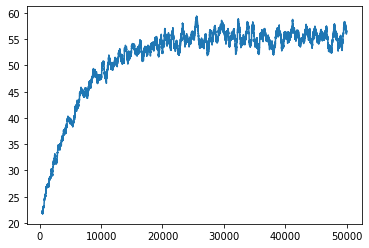

In [0]:
reward = [np.mean(total_rewards[-400 + i:i]) for i in range(len(total_rewards))]
plt.plot(reward)